# Z PRINTAMI

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.python.keras.utils import conv_utils

class PartialConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='same', activation=None, **kwargs):
        super(PartialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)  # Convert activation string to a callable function
        self.conv = None
        self.mask_conv = None

    def build(self, input_shape):
        # Ensure input_shape is a tuple, regardless of whether it's initially a list or TensorShape
        if isinstance(input_shape, (tuple, list)):
            input_shape_tuple = tuple(input_shape)
        else:
            input_shape_tuple = tuple(input_shape.as_list())

        input_dim = input_shape_tuple[-1]

        # Define the regular convolutional layer
        self.conv = layers.Conv2D(self.filters, self.kernel_size, strides=self.strides, 
                              padding=self.padding, use_bias=False)
        self.conv.build(input_shape_tuple)  # Pass tuple instead of TensorShape or list

        # Define mask_conv with kernel shape appropriate for mask processing (single input channel)
        mask_input_channels = 1  # Number of input channels for the mask is 1
        self.mask_conv = layers.Conv2D(self.filters, self.kernel_size, strides=self.strides, 
                                   padding=self.padding, use_bias=False, trainable=False,
                                   kernel_initializer=tf.initializers.Ones())  # Initialize kernel with ones
        self.mask_conv.build((input_shape_tuple[0], input_shape_tuple[1], input_shape_tuple[2], mask_input_channels))  # Build with mask shape (single input channel)

        self.built = True


    def call(self, inputs, mask=None):
        if mask is None:
            mask = tf.ones_like(inputs)[:, :, :, :1]  # Use only the first channel if mask is not provided
    
        # Ensure mask has only 1 channel
        if mask.shape[-1] != 1:
            mask = mask[:, :, :, :1]  # Use only the first channel of the mask
    
        # Apply convolutions
        output = self.conv(inputs)
        mask_output = self.mask_conv(mask)

        # Sum over the channels
        sum_output = tf.reduce_sum(tf.ones_like(output), axis=-1)
        sum_mask_output = tf.reduce_sum(mask_output, axis=-1)

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = sum_output / (sum_mask_output + 1e-8)

        # Clip the mask ratio to be between 0 and 1
        mask_ratio = tf.clip_by_value(mask_ratio, 0, 1)

        # Expand the mask ratio dimensions to match output for element-wise multiplication
        mask_ratio = tf.expand_dims(mask_ratio, axis=-1)

        # Apply the mask ratio to the output
        output = output * mask_ratio

        # Apply activation function
        if self.activation is not None:
            output = self.activation(output)

        return output, mask_output


class AdjustShapeLayer(layers.Layer):
    def call(self, inputs, target_shape):
        input_shape = tf.shape(inputs)[1:3]
        target_shape = tf.shape(target_shape)[1:3]

        height_diff = target_shape[0] - input_shape[0]
        width_diff = target_shape[1] - input_shape[1]

        paddings = tf.convert_to_tensor([[0, 0], [0, height_diff], [0, width_diff], [0, 0]])
        padded = tf.pad(inputs, paddings, mode='REFLECT')
        return padded

    def compute_output_shape(self, input_shape, target_shape):
        # The output height and width are adjusted to match the target_shape
        # The number of channels remains the same as in the input_shape
        return (input_shape[0], target_shape[1], target_shape[2], input_shape[3])
    


class ContextualAttention(layers.Layer):
    def __init__(self, ksize=3, stride=1, rate=2, **kwargs):
        super(ContextualAttention, self).__init__(**kwargs)
        self.ksize = ksize
        self.stride = stride
        self.rate = rate

    def call(self, inputs):
        foreground, background = inputs

        # Hardcoded shapes (modify these according to your specific dimensions)
        foreground_shape = (32, 640, 480, 3)  # Example: (batch_size, height, width, channels)
        background_shape = (32, 640, 480, 3)  # Example: (batch_size, height, width, channels)

        # Extract patches from the background with stride and rate
        kernel = 2 * self.rate + self.ksize
        raw_w = tf.image.extract_patches(
            background, sizes=[1, kernel, kernel, 1], strides=[1, self.stride, self.stride, 1],
            rates=[1, self.rate, self.rate, 1], padding='SAME')

        # Reshape extracted patches
        raw_w = tf.reshape(raw_w, [background_shape[0], -1, self.ksize, self.ksize, background_shape[-1]])
        raw_w = raw_w[:, :, self.rate:self.rate + self.ksize, self.rate:self.rate + self.ksize, :]

        # Normalize and reshape patches
        raw_w = tf.nn.l2_normalize(raw_w, axis=[2, 3, 4])

        # Reshape foreground to prepare for patch comparisons
        f = tf.reshape(foreground, [foreground_shape[0], -1, foreground_shape[-1]])
        f = tf.nn.l2_normalize(f, axis=2)

        # Perform patch comparisons
        s = tf.matmul(f, raw_w, transpose_b=True)

        # Softmax to get attention scores
        a = tf.nn.softmax(s, axis=-1)

        # Weighted sum of background patches (attended features)
        o = tf.matmul(a, tf.reshape(raw_w, [background_shape[0], -1, background_shape[-1]]))
        o = tf.reshape(o, shape=foreground_shape)

        # Scaling factor for preserving the amplitude of feature responses
        scaling_factor = tf.cast(tf.size(self.ksize), dtype=tf.float32) ** -0.5
        o *= scaling_factor

        return o

def conv_block(input_tensor, mask_tensor, num_filters):
    #print(f"conv_block input: {input_tensor.shape}, mask: {mask_tensor.shape}")
    conv_layer1 = PartialConv2D(num_filters, (3, 3), padding='same', activation='relu')
    x, mask = conv_layer1(input_tensor, mask_tensor)
    #print(f"conv_block conv_layer1: {x.shape}, mask: {mask.shape}")
    
    conv_layer2 = PartialConv2D(num_filters, (3, 3), padding='same', activation='relu')
    x, mask = conv_layer2(x, mask)
    #print(f"conv_block conv_layer2: {x.shape}, mask: {mask.shape}")
    
    return x, mask

def encoder_block(input_tensor, mask_tensor, num_filters):
    #print(f"encoder_block input: {input_tensor.shape}, mask: {mask_tensor.shape}")
    x, mask = conv_block(input_tensor, mask_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    #print(f"encoder_block pooled: {p.shape}")
    mask_p = layers.MaxPooling2D((2, 2))(mask)
    #print(f"encoder_block mask_pooled: {mask_p.shape}")
    return x, mask, p, mask_p

def decoder_block(input_tensor, mask_tensor, concat_tensor, concat_mask_tensor, num_filters):
    adjust_shape_layer = AdjustShapeLayer()
    
    # Upsample the input_tensor and mask_tensor
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    mask = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(mask_tensor)

    # Adjust the shape of x and mask to match concat_tensor if necessary
    x = adjust_shape_layer(x, concat_tensor)
    mask = adjust_shape_layer(mask, concat_mask_tensor)

    # Now we can safely concatenate
    x = layers.concatenate([x, concat_tensor])
    mask = layers.concatenate([mask, concat_mask_tensor])

    x, mask = conv_block(x, mask, num_filters)
    return x, mask


def edge_generation_network(input_size=(640, 480, 3)):
    inputs = tf.keras.Input(input_size)
    mask_inputs = tf.keras.Input(input_size, name='mask')

    # Contracting Path (Encoder)
    c1, mask1, p1, mask_p1 = encoder_block(inputs, mask_inputs, 64)
    c2, mask2, p2, mask_p2 = encoder_block(p1, mask_p1, 128)
    c3, mask3, p3, mask_p3 = encoder_block(p2, mask_p2, 256)
    c4, mask4, p4, mask_p4 = encoder_block(p3, mask_p3, 512)
    
    # Bottleneck
    b, mask_b = conv_block(p4, mask_p4, 1024)

    # Expansive Path (Decoder)
    d1, mask_d1 = decoder_block(b, mask_b, c4, mask4, 512)
    d2, mask_d2 = decoder_block(d1, mask_d1, c3, mask3, 256)
    d3, mask_d3 = decoder_block(d2, mask_d2, c2, mask2, 128)
    d4, mask_d4 = decoder_block(d3, mask_d3, c1, mask1, 64)

    # Output layer for edge prediction (use 'sigmoid' activation for normalized [0, 1] edge maps)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs=[inputs, mask_inputs], outputs=[outputs])
    return model


def image_completion_network(input_size, edge_map_shape):
    inputs = tf.keras.Input(input_size)
    mask_inputs = tf.keras.Input(input_size, name='mask')
    edge_inputs = tf.keras.Input(edge_map_shape, name='edge_maps')

    #print(f"image_completion_network inputs: {inputs.shape}, mask_inputs: {mask_inputs.shape}, edge_inputs: {edge_inputs.shape}")

    c1, mask1, p1, mask_p1 = encoder_block(inputs, mask_inputs, 64)
    c2, mask2, p2, mask_p2 = encoder_block(p1, mask_p1, 128)
    c3, mask3, p3, mask_p3 = encoder_block(p2, mask_p2, 256)
    c4, mask4, p4, mask_p4 = encoder_block(p3, mask_p3, 512)

    b, mask_b = conv_block(p4, mask_p4, 1024)

    contextual_attention_layer = ContextualAttention(ksize=3, stride=1, rate=2)
    b = contextual_attention_layer([b, b])

    d1, mask_d1 = decoder_block(b, mask_b, c4, mask4, 512)
    d2, mask_d2 = decoder_block(d1, mask_d1, c3, mask3, 256)
    d3, mask_d3 = decoder_block(d2, mask_d2, c2, mask2, 128)
    d4, mask_d4 = decoder_block(d3, mask_d3, c1, mask1, 64)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs=[inputs, mask_inputs, edge_inputs], outputs=[outputs])
    return model


input_size = (640, 480, 3)  # Adjusting input size to (640, 480, 3)
inputs = tf.keras.Input(input_size)
mask_inputs = tf.keras.Input(input_size, name='mask')

edge_model = edge_generation_network(input_size)
edge_maps = edge_model([inputs, mask_inputs])

edge_map_shape = (640, 480, 1)  # Adjusting edge map shape to (640, 480, 1)
completion_model = image_completion_network(input_size, edge_map_shape)

# Complete the image using the generated edge maps
completed_image = completion_model([inputs, mask_inputs, edge_maps])

final_model = models.Model(inputs=[inputs, mask_inputs], outputs=[completed_image])
final_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
final_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 mask (InputLayer)           [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 640, 480, 1)          3386508   ['input_1[0][0]',             
                                                          9          'mask[0][0]']                
                                                                                                  
 model_1 (Functional)        (32, 640, 480, 3)            3177421   ['input_1[0][0]',       

# GŁÓWNY MODEL

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
#from tensorflow.keras.utils import conv_utils
from tensorflow.python.keras.utils import conv_utils
#import tensorflow.keras.utils as conv_utils

class PartialConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='same', activation=None, **kwargs):
        super(PartialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)  # Convert activation string to a callable function
        self.conv = None
        self.mask_conv = None

    def build(self, input_shape):
        # Ensure input_shape is a tuple, regardless of whether it's initially a list or TensorShape
        if isinstance(input_shape, (tuple, list)):
            input_shape_tuple = tuple(input_shape)
        else:
            input_shape_tuple = tuple(input_shape.as_list())

        input_dim = input_shape_tuple[-1]
        
        # Check if input_dim is an integer, raise an error if not
        if not isinstance(input_dim, int):
            raise TypeError(f"Expected input_dim to be an integer, got {input_dim} of type {type(input_dim)}")
        
        self.conv = layers.Conv2D(self.filters, self.kernel_size, strides=self.strides, 
                                  padding=self.padding, use_bias=False)
        self.conv.build(input_shape_tuple)  # Pass tuple instead of TensorShape or list

        self.mask_conv = layers.Conv2D(self.filters, self.kernel_size, strides=self.strides, 
                                       padding=self.padding, use_bias=False, trainable=False)
        self.mask_conv.build(input_shape_tuple)  # Pass tuple instead of TensorShape or list

        
        # Ensure kernel size is a tuple of integers
        if isinstance(self.kernel_size, int):
            kernel_size_tuple = (self.kernel_size, self.kernel_size)
        elif isinstance(self.kernel_size, tuple) and all(isinstance(dim, int) for dim in self.kernel_size):
            kernel_size_tuple = self.kernel_size
        else:
            raise ValueError("kernel_size must be an int or a tuple of two ints")

        kernel_shape = kernel_size_tuple + (input_dim, self.filters)
        self.mask_conv.kernel.assign(tf.ones(kernel_shape))
        
        self.built = True

    def call(self, inputs, mask=None):
        if mask is None:
            mask = tf.ones_like(inputs)
        
        # Apply convolutions
        output = self.conv(inputs)
        mask_output = self.mask_conv(mask)

        # Sum over the channels
        sum_output = tf.reduce_sum(tf.ones_like(output), axis=-1)
        sum_mask_output = tf.reduce_sum(mask_output, axis=-1)

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = sum_output / (sum_mask_output + 1e-8)

        # Clip the mask ratio to be between 0 and 1
        mask_ratio = tf.clip_by_value(mask_ratio, 0, 1)

        # Expand the mask ratio dimensions to match output for element-wise multiplication
        mask_ratio = tf.expand_dims(mask_ratio, axis=-1)

        # Apply the mask ratio to the output
        output = output * mask_ratio

        # Apply activation function
        if self.activation is not None:
            output = self.activation(output)

        return output, mask_output


class ContextualAttention(layers.Layer):
    def __init__(self, ksize=3, stride=1, rate=2, **kwargs):
        super(ContextualAttention, self).__init__(**kwargs)
        self.ksize = ksize
        self.stride = stride
        self.rate = rate

    def call(self, inputs):
        # Unpack inputs: foreground and background features
        foreground, background = inputs

        # Get shapes
        raw_int_fs = tf.shape(foreground)
        raw_int_bs = tf.shape(background)
    
        # Extract patches from the background with stride and rate
        kernel = 2 * self.rate + self.ksize
        raw_w = tf.image.extract_patches(
            background, sizes=[1, kernel, kernel, 1], strides=[1, self.stride, self.stride, 1], rates=[1, self.rate, self.rate, 1], padding='SAME')
    
        # Reshape extracted patches
        raw_w = tf.reshape(raw_w, [raw_int_bs[0], -1, kernel, kernel, raw_int_bs[-1]])
        raw_w = raw_w[:, :, self.rate:self.rate + self.ksize, self.rate:self.rate + self.ksize, :]

        # Normalize and reshape patches
        raw_w = tf.nn.l2_normalize(raw_w, axis=[2, 3, 4])

        # Reshape foreground to prepare for patch comparisons
        f = tf.reshape(foreground, [raw_int_fs[0], -1, raw_int_fs[-1]])
        f = tf.nn.l2_normalize(f, axis=2)
    
        # Perform patch comparisons
        s = tf.matmul(f, raw_w, transpose_b=True)
    
        # Softmax to get attention scores
        a = tf.nn.softmax(s, axis=-1)
    
        # Weighted sum of background patches (attended features)
        o = tf.matmul(a, tf.reshape(raw_w, [raw_int_bs[0], -1, raw_int_bs[-1]]))
        o = tf.reshape(o, shape=raw_int_fs)
    
        # Scaling factor for preserving the amplitude of feature responses
        # Convert tf.size(self.ksize) to float before exponentiation
        scaling_factor = tf.cast(tf.size(self.ksize), dtype=tf.float32) ** -0.5
        o *= scaling_factor
        
        return o


    def compute_output_shape(self, input_shape):
        space = input_shape[1:-1]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding=self.padding,
                stride=self.strides[i],
                dilation=self.dilation_rate[i]
            )
            new_space.append(new_dim)
        return (input_shape[0],) + tuple(new_space) + (self.filters,)

    
def conv_block(input_tensor, mask_tensor, num_filters):
    conv_layer1 = PartialConv2D(num_filters, (3, 3), padding='same', activation='relu')
    x, mask = conv_layer1(input_tensor, mask_tensor)
    
    conv_layer2 = PartialConv2D(num_filters, (3, 3), padding='same', activation='relu')
    x, mask = conv_layer2(x, mask)
    
    return x, mask

def encoder_block(input_tensor, mask_tensor, num_filters):
    """An encoder block: a conv_block followed by a MaxPooling2D."""
    x, mask = conv_block(input_tensor, mask_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    mask_p = layers.MaxPooling2D((2, 2))(mask)
    return x, mask, p, mask_p

def decoder_block(input_tensor, mask_tensor, concat_tensor, concat_mask_tensor, num_filters):
    """A decoder block."""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    mask = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(mask_tensor)
    x = layers.concatenate([x, concat_tensor])
    mask = layers.concatenate([mask, concat_mask_tensor])
    x, mask = conv_block(x, mask, num_filters)
    return x, mask


#def edge_generation_network(input_size=(256, 256, 3)):
def edge_generation_network(input_size=(640, 480, 3)):
    inputs = tf.keras.Input(input_size)
    mask_inputs = tf.keras.Input(input_size, name='mask')

    # Contracting Path (Encoder)
    c1, mask1, p1, mask_p1 = encoder_block(inputs, mask_inputs, 64)
    c2, mask2, p2, mask_p2 = encoder_block(p1, mask_p1, 128)
    c3, mask3, p3, mask_p3 = encoder_block(p2, mask_p2, 256)
    c4, mask4, p4, mask_p4 = encoder_block(p3, mask_p3, 512)
    
    # Bottleneck
    b, mask_b = conv_block(p4, mask_p4, 1024)

    # Expansive Path (Decoder)
    d1, mask_d1 = decoder_block(b, mask_b, c4, mask4, 512)
    d2, mask_d2 = decoder_block(d1, mask_d1, c3, mask3, 256)
    d3, mask_d3 = decoder_block(d2, mask_d2, c2, mask2, 128)
    d4, mask_d4 = decoder_block(d3, mask_d3, c1, mask1, 64)

    # Output layer for edge prediction (use 'sigmoid' activation for normalized [0, 1] edge maps)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs=[inputs, mask_inputs], outputs=[outputs])
    return model


def image_completion_network(input_size, edge_map_shape):
    inputs = tf.keras.Input(input_size)
    mask_inputs = tf.keras.Input(input_size, name='mask')
    edge_inputs = tf.keras.Input(edge_map_shape, name='edge_maps')  # Correctly defined shape

    # Contracting Path
    c1, mask1, p1, mask_p1 = encoder_block(inputs, mask_inputs, 64)
    c2, mask2, p2, mask_p2 = encoder_block(p1, mask_p1, 128)
    c3, mask3, p3, mask_p3 = encoder_block(p2, mask_p2, 256)
    c4, mask4, p4, mask_p4 = encoder_block(p3, mask_p3, 512)

    # Bottleneck with Contextual Attention
    b, mask_b = conv_block(p4, mask_p4, 1024)

    # Instantiate and call the ContextualAttention layer
    contextual_attention_layer = ContextualAttention(ksize=3, stride=1, rate=2)
    b = contextual_attention_layer([b, b])  # Self attention, replace with appropriate background if available

    # Expansive Path
    d1, mask_d1 = decoder_block(b, mask_b, c4, mask4, 512)
    d2, mask_d2 = decoder_block(d1, mask_d1, c3, mask3, 256)
    d3, mask_d3 = decoder_block(d2, mask_d2, c2, mask2, 128)
    d4, mask_d4 = decoder_block(d3, mask_d3, c1, mask1, 64)

    # Output layer for image completion
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs=[inputs, mask_inputs, edge_inputs], outputs=[outputs])
    return model

# Main integration of edge generation and image completion networks
input_size = (640, 480, 3)  # Adjusting input size to (640, 480, 3)
inputs = tf.keras.Input(input_size)
mask_inputs = tf.keras.Input(input_size, name='mask')

# Generate edge maps
edge_model = edge_generation_network(input_size)
edge_maps = edge_model([inputs, mask_inputs])

# Define the shape of edge_maps explicitly for the image_completion_network
edge_map_shape = (640, 480, 1)  # Adjusting edge map shape to (640, 480, 1)

# Complete the image using the generated edge maps
completion_model = image_completion_network(input_size, edge_map_shape)
completed_image = completion_model([inputs, mask_inputs, edge_maps])

# Define the final integrated model
final_model = models.Model(inputs=[inputs, mask_inputs], outputs=[completed_image])

# Compile the final integrated model
final_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Model summary
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 mask (InputLayer)           [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 640, 480, 1)          6205164   ['input_1[0][0]',             
                                                          9          'mask[0][0]']                
                                                                                                  
 model_1 (Functional)        (None, 640, 480, 3)          6205177   ['input_1[0][0]',       

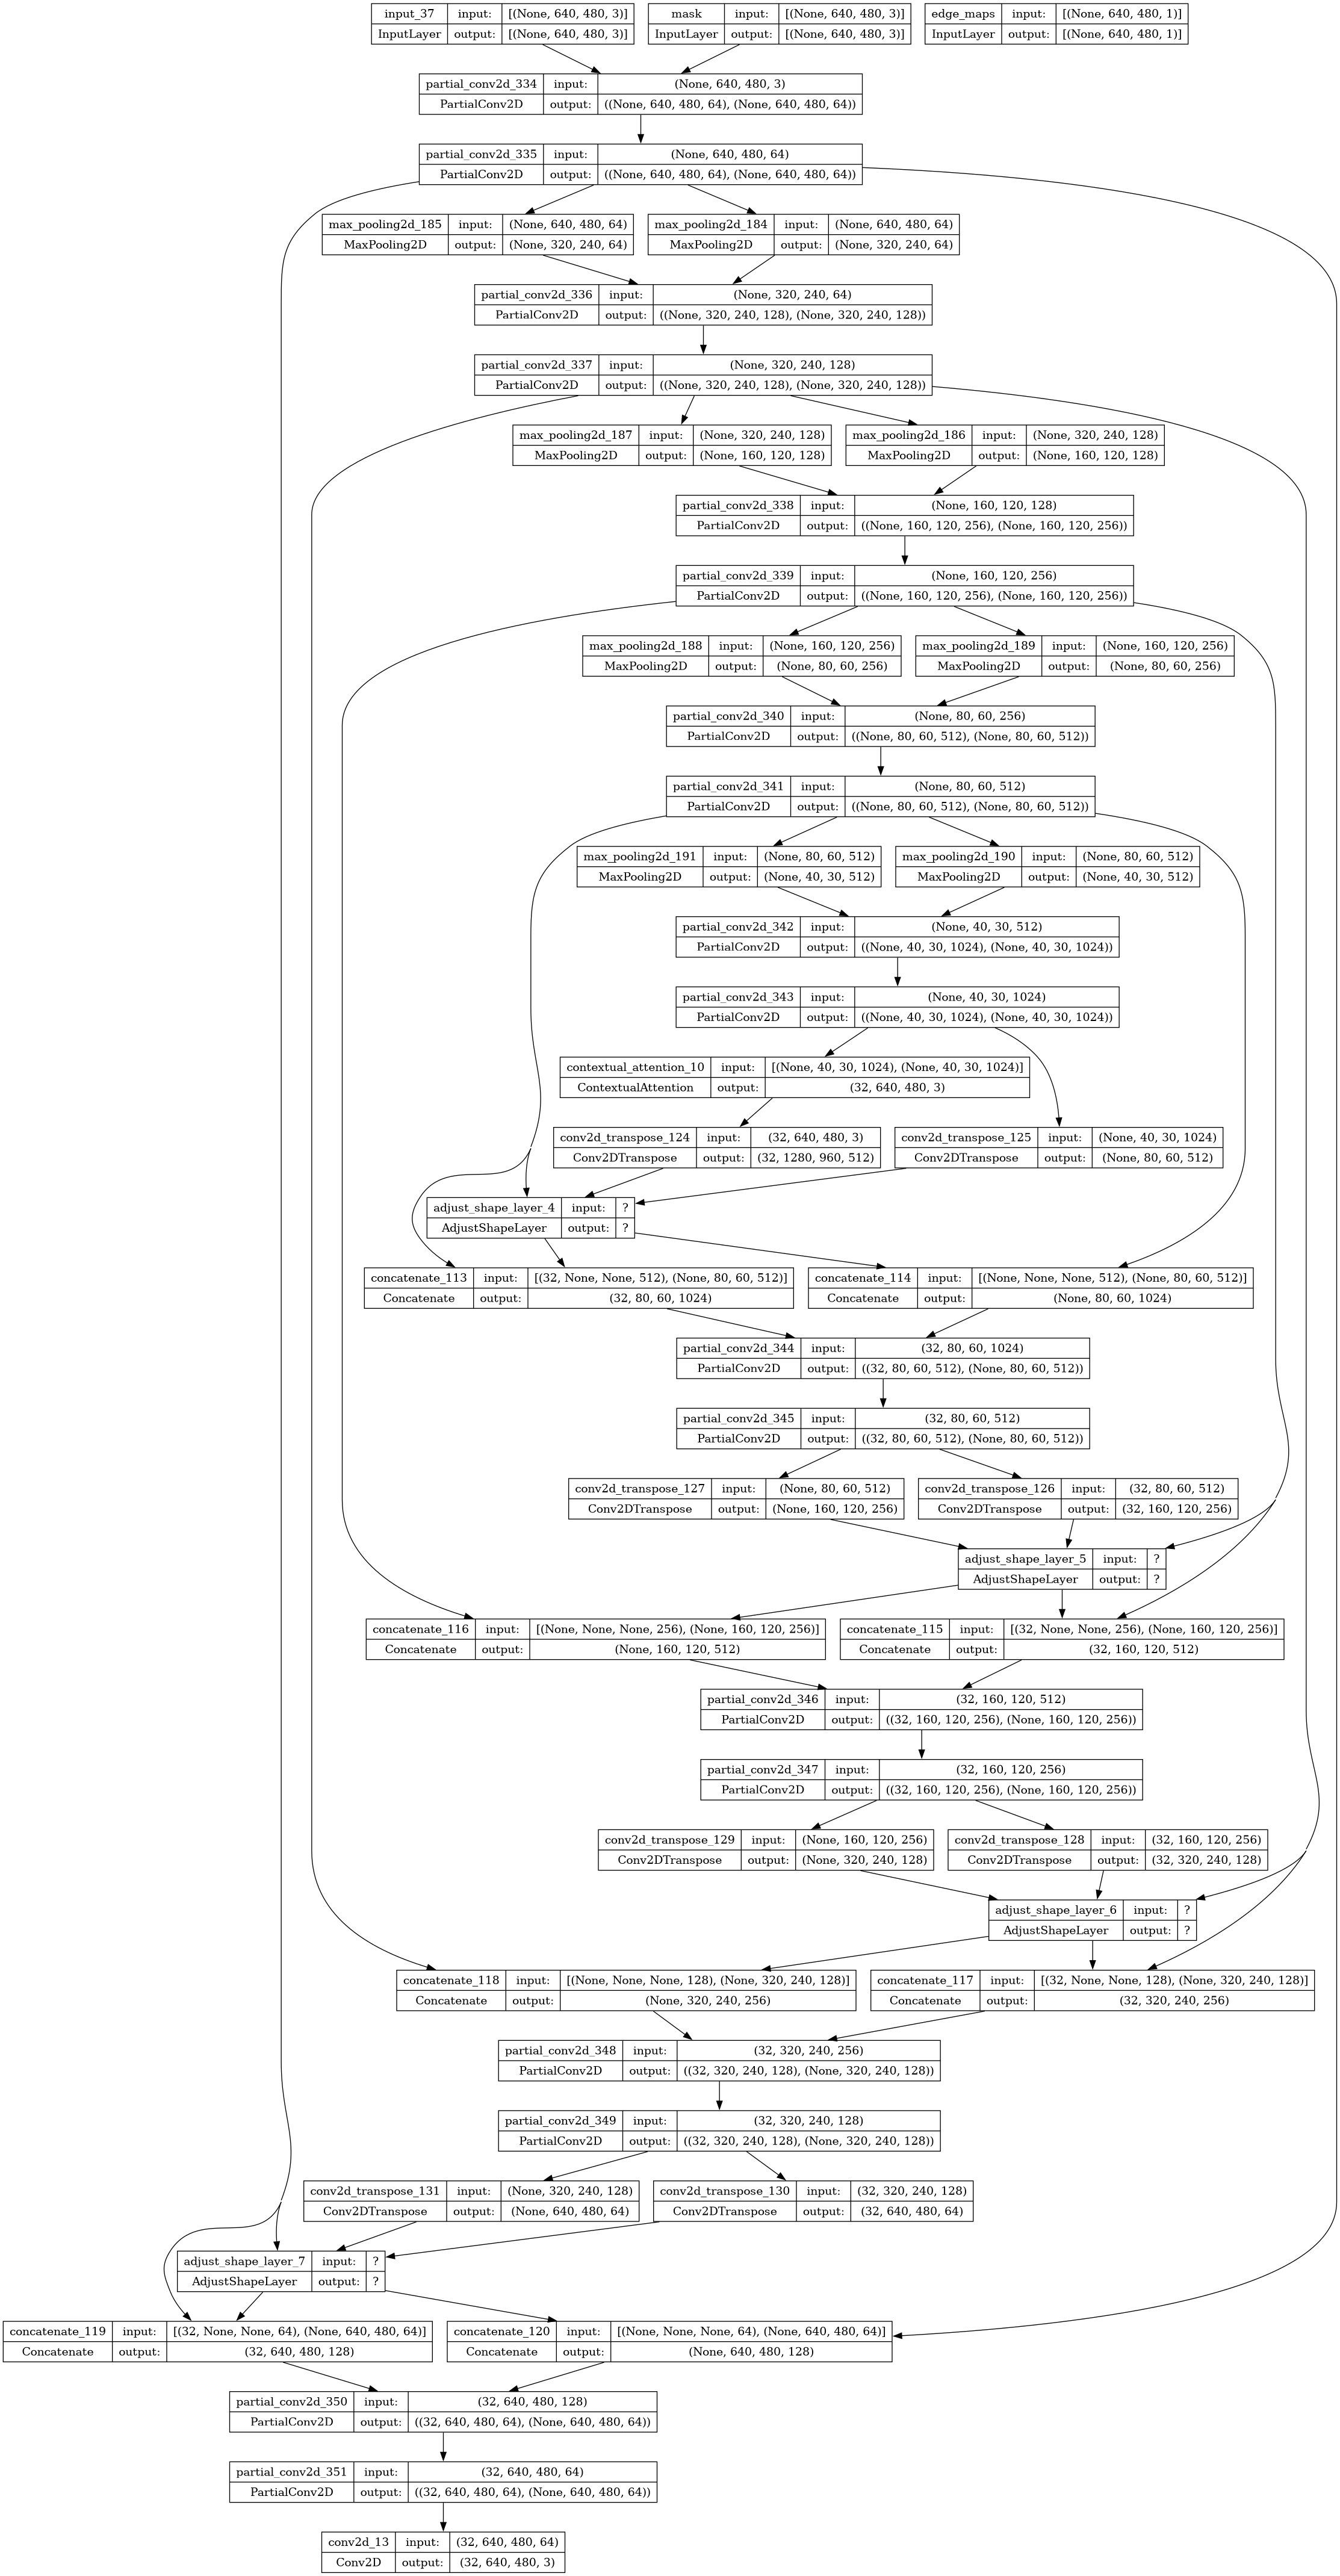

In [18]:
# Plot the model and display the architecture
plot_model(completion_model, to_file='completion.png', show_shapes=True, show_layer_names=True)

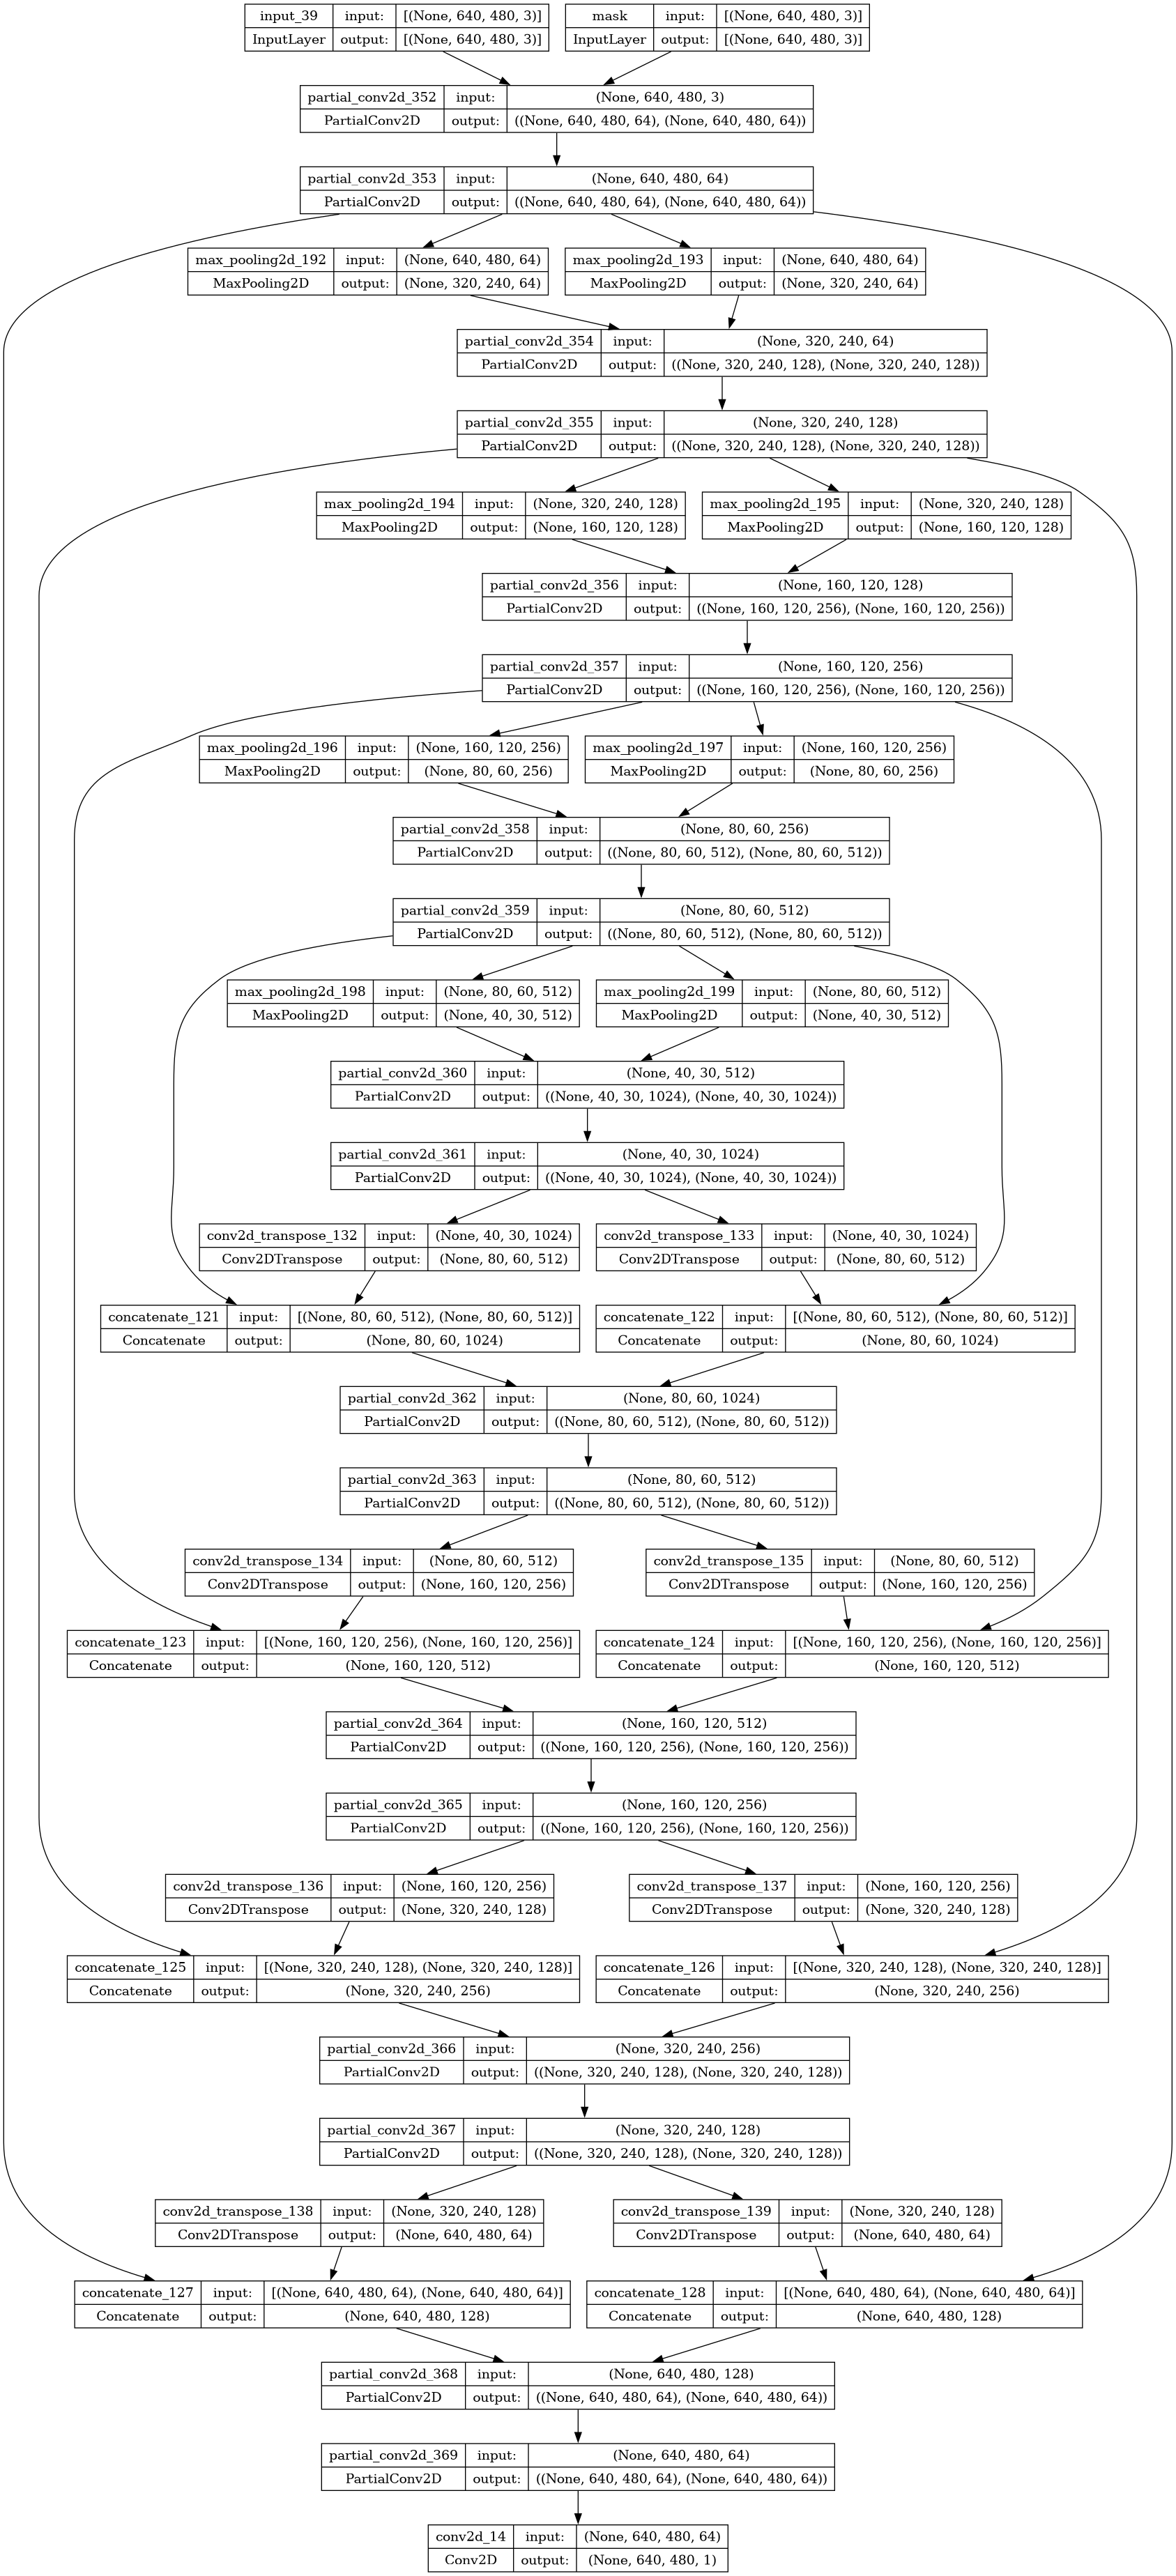

In [19]:
# Plot the model and display the architecture
plot_model(edge_model, to_file='edge.png', show_shapes=True, show_layer_names=True)

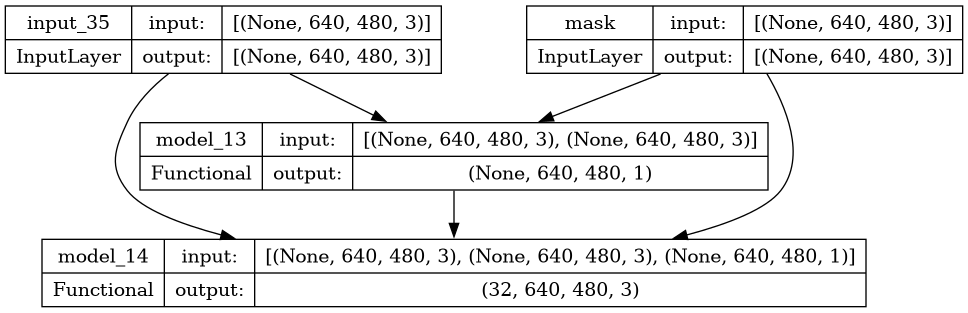

In [17]:
from tensorflow.keras.utils import plot_model

# Plot the model and display the architecture
plot_model(final_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [20]:
completion_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 mask (InputLayer)           [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 partial_conv2d_334 (Partia  ((None, 640, 480, 64),       2304      ['input_37[0][0]',            
 lConv2D)                     (None, 640, 480, 64))                  'mask[0][0]']                
                                                                                                  
 partial_conv2d_335 (Partia  ((None, 640, 480, 64),       37440     ['partial_conv2d_334[0]

In [21]:
edge_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 mask (InputLayer)           [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 partial_conv2d_352 (Partia  ((None, 640, 480, 64),       2304      ['input_39[0][0]',            
 lConv2D)                     (None, 640, 480, 64))                  'mask[0][0]']                
                                                                                                  
 partial_conv2d_353 (Partia  ((None, 640, 480, 64),       37440     ['partial_conv2d_352[0]

In [22]:
num_layers = len(final_model.layers)
print(f"The total number of layers in the final model is: {num_layers}")

The total number of layers in the final model is: 4


In [23]:
num_layers = len(edge_model.layers)
print(f"The total number of layers in the edge model is: {num_layers}")

The total number of layers in the edge model is: 45


In [24]:
num_layers = len(completion_model.layers)
print(f"The total number of layers in the completion model is: {num_layers}")

The total number of layers in the completion model is: 51


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def create_inpainting_dataset(image_dir, target_size=(256, 256), mask_size=(64, 64)):
    """
    Create a dataset of images with rectangular masks for inpainting.
    Args:
    - image_dir (str): Directory with images.
    - target_size (tuple): The desired size of the output images.
    - mask_size (tuple): The size of the rectangular mask.
    Returns:
    - images (np.array): Array of original images.
    - masked_images (np.array): Array of images with masks.
    - masks (np.array): Array of mask images.
    """
    images = []
    masked_images = []
    masks = []
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0  # Normalize images

        mask = np.zeros(target_size + (1,), dtype=np.float32)
        top_left_x = np.random.randint(0, target_size[0] - mask_size[0])
        top_left_y = np.random.randint(0, target_size[1] - mask_size[1])
        mask[top_left_x:top_left_x+mask_size[0], top_left_y:top_left_y+mask_size[1], :] = 1

        masked_img = img.copy()
        masked_img[mask[:,:,0] == 1] = 1  # Assuming the mask should cover with white color

        images.append(img)
        masked_images.append(masked_img)
        masks.append(mask)

    return np.array(images), np.array(masked_images), np.array(masks)

def train_model(model, images, masked_images, masks, batch_size, epochs):
    """
    Train the inpainting model.
    Args:
    - model: The inpainting model.
    - images (np.array): Array of original images.
    - masked_images (np.array): Array of images with masks.
    - masks (np.array): Array of mask images.
    - batch_size (int): Batch size for training.
    - epochs (int): Number of epochs for training.
    """
    callbacks = [
        ModelCheckpoint('best_inpainting_model.h5', save_best_only=True),
        EarlyStopping(patience=10, restore_best_weights=True)
    ]

    history = model.fit(
        x=[masked_images, masks],
        y=images,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=callbacks
    )
    return history

# Define paths
train_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/val2017'

# Create datasets
train_images, train_masked_images, train_masks = create_inpainting_dataset(train_image_dir)
val_images, val_masked_images, val_masks = create_inpainting_dataset(val_image_dir)

# Train the model
history = train_model(final_model, train_images, train_masked_images, train_masks, batch_size=32, epochs=100)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate on test set (assuming you have a test set prepared in a similar way)
test_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/test2017'
test_images, test_masked_images, test_masks = create_inpainting_dataset(test_image_dir)
test_loss = final_model.evaluate([test_masked_images, test_masks], test_images)

# Save the model
final_model.save('final_inpainting_model.h5')


# TO SAMO CO WYZEJ ALE Z GENERATOREM

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import math

class InpaintingDataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, target_size=(256, 256), mask_size=(64, 64)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.batch_size = batch_size
        self.target_size = target_size
        self.mask_size = mask_size

    def __len__(self):
        return math.ceil(len(self.image_names) / self.batch_size)

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, len(self.image_names))
        batch_image_names = self.image_names[batch_start:batch_end]

        images, masked_images, masks = [], [], []
        original_sizes = []
        for img_name in batch_image_names:
            img_path = os.path.join(self.image_dir, img_name)
            img = load_img(img_path)
            original_size = img.size
            original_sizes.append(original_size)  # Store original image size
            img = img.resize(self.target_size)  # Resize for model input
            img = img_to_array(img) / 255.0  # Normalize images

            mask = np.zeros((self.target_size[0], self.target_size[1], 1), dtype=np.float32)
            top_left_x = np.random.randint(0, self.target_size[0] - self.mask_size[0])
            top_left_y = np.random.randint(0, self.target_size[1] - self.mask_size[1])
            mask[top_left_x:top_left_x + self.mask_size[0], top_left_y:top_left_y + self.mask_size[1], :] = 1

            masked_img = img.copy()
            masked_img[mask[:, :, 0] == 1] = 1  # Mask with white color

            images.append(img)
            masked_images.append(masked_img)
            masks.append(mask)

        return [np.array(masked_images), np.array(masks)], np.array(images), original_sizes
    

train_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
test_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/test2017'

# Create data generators
batch_size = 32
train_generator = InpaintingDataGenerator(train_image_dir, batch_size)
val_generator = InpaintingDataGenerator(val_image_dir, batch_size)
test_generator = InpaintingDataGenerator(test_image_dir, batch_size)

# Train the model
callbacks = [
    ModelCheckpoint('best_inpainting_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = final_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate on test set
test_loss = final_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')

# Save the model
final_model.save('final_inpainting_model.h5')

In [37]:
import cv2

def get_image_dimensions_cv2(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Check if the image was read successfully
    if image is None:
        raise Exception(f"Failed to read image: {image_path}")

    # Get the image dimensions
    height, width, channels = image.shape

    return height, width

print(get_image_dimensions_cv2("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg"))

(640, 480)


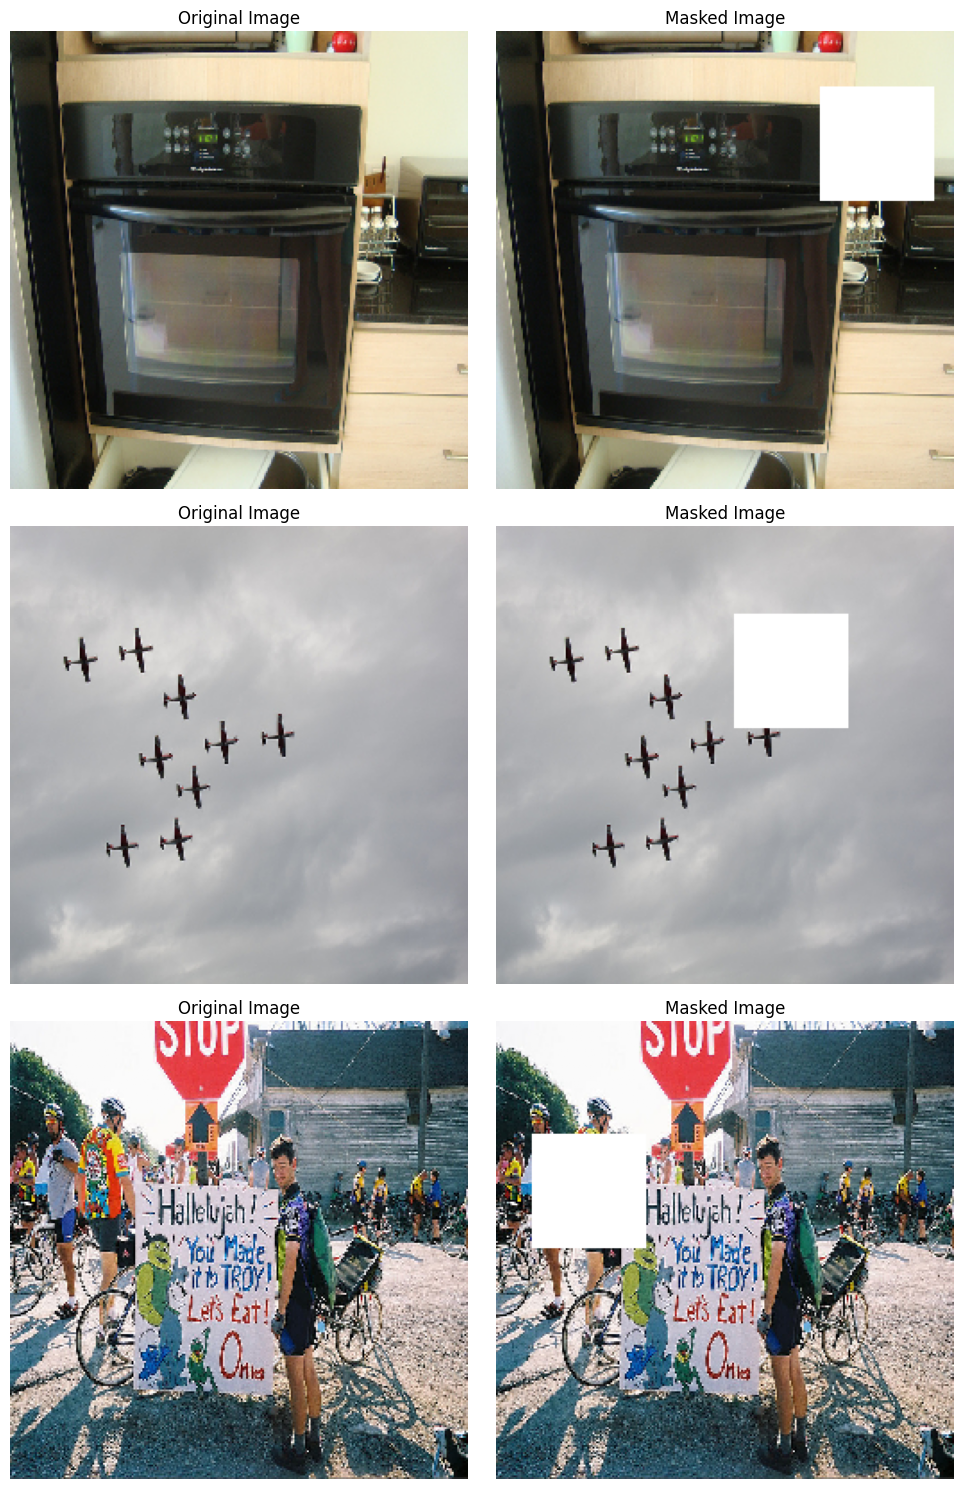

In [10]:
import matplotlib.pyplot as plt
import os

train_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/val2017'


class InpaintingDataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, target_size=(256, 256), mask_size=(64, 64)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.batch_size = batch_size
        self.target_size = target_size
        self.mask_size = mask_size
        
    def __len__(self):
        return math.ceil(len(self.image_names) / self.batch_size)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        length = min(self.batch_size, (len(self.image_names) - i))
        batch_image_names = self.image_names[i:i+length]

        images = []
        masked_images = []
        masks = []

        for img_name in batch_image_names:
            img_path = os.path.join(self.image_dir, img_name)
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img) / 255.0  # Normalize images

            mask = np.zeros(self.target_size + (1,), dtype=np.float32)
            top_left_x = np.random.randint(0, self.target_size[0] - self.mask_size[0])
            top_left_y = np.random.randint(0, self.target_size[1] - self.mask_size[1])
            mask[top_left_x:top_left_x+self.mask_size[0], top_left_y:top_left_y+self.mask_size[1], :] = 1

            masked_img = img.copy()
            masked_img[mask[:,:,0] == 1] = 1  # Assuming the mask should cover with white color

            images.append(img)
            masked_images.append(masked_img)
            masks.append(mask)

        return [np.array(masked_images), np.array(masks)], np.array(images)

# Usage example:
train_generator = InpaintingDataGenerator(train_image_dir, batch_size=32)

def display_image_pairs(generator, num_samples=3):
    """
    Display original and masked images side by side for comparison,
    directly using the data from the generator.
    
    Args:
    - generator (InpaintingDataGenerator): The generator that yields batches of data.
    - num_samples (int): Number of samples to display.
    """
    plt.figure(figsize=(10, 5 * num_samples))
    
    # Get a batch of data
    data = next(iter(generator))
    masked_images, masks = data[0]  # data[0] contains masked_images and masks
    original_images = data[1]       # data[1] contains original images
    
    for i in range(num_samples):
        # Display original image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image")
        plt.axis('off')
        
        # Display masked image
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masked_images[i])
        plt.title("Masked Image")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage example with the train_generator
display_image_pairs(train_generator, num_samples=3)

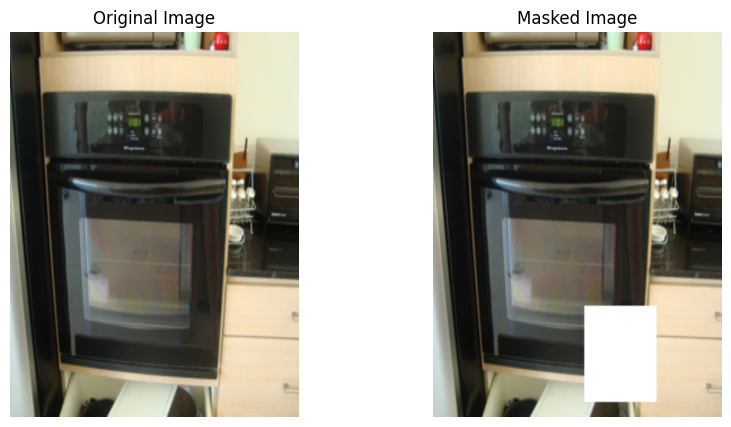

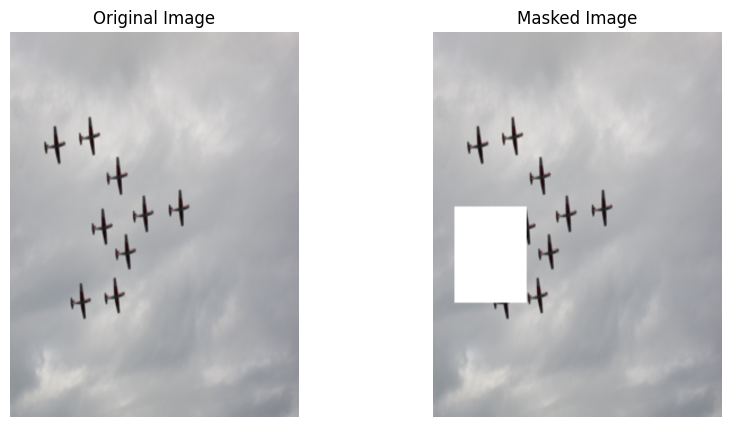

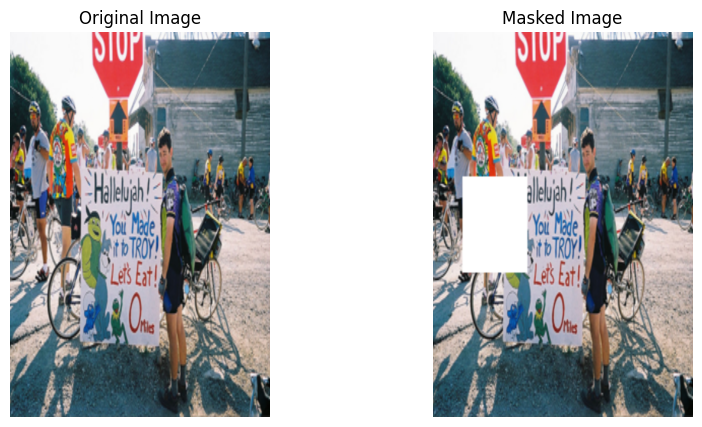

In [13]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import tensorflow as tf

class InpaintingDataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, target_size=(256, 256), mask_size=(64, 64)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.batch_size = batch_size
        self.target_size = target_size
        self.mask_size = mask_size

    def __len__(self):
        return math.ceil(len(self.image_names) / self.batch_size)

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, len(self.image_names))
        batch_image_names = self.image_names[batch_start:batch_end]

        images, masked_images, masks = [], [], []
        original_sizes = []
        for img_name in batch_image_names:
            img_path = os.path.join(self.image_dir, img_name)
            img = load_img(img_path)
            original_size = img.size
            original_sizes.append(original_size)  # Store original image size
            img = img.resize(self.target_size)  # Resize for model input
            img = img_to_array(img) / 255.0  # Normalize images

            mask = np.zeros((self.target_size[0], self.target_size[1], 1), dtype=np.float32)
            top_left_x = np.random.randint(0, self.target_size[0] - self.mask_size[0])
            top_left_y = np.random.randint(0, self.target_size[1] - self.mask_size[1])
            mask[top_left_x:top_left_x + self.mask_size[0], top_left_y:top_left_y + self.mask_size[1], :] = 1

            masked_img = img.copy()
            masked_img[mask[:, :, 0] == 1] = 1  # Mask with white color

            images.append(img)
            masked_images.append(masked_img)
            masks.append(mask)

        return [np.array(masked_images), np.array(masks)], np.array(images), original_sizes
    
def display_image_pairs(generator, num_samples=3):
    data, original_images, original_sizes = next(iter(generator))
    masked_images, masks = data
    
    for i in range(num_samples):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        original_size = original_sizes[i]
        
        # Resize images back to original size for display
        original_img_resized = tf.image.resize(original_images[i], original_size).numpy()
        masked_img_resized = tf.image.resize(masked_images[i], original_size).numpy()

        axs[0].imshow(original_img_resized)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(masked_img_resized)
        axs[1].set_title("Masked Image")
        axs[1].axis('off')

        plt.show()

# Usage example:
train_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
train_generator = InpaintingDataGenerator(train_image_dir, batch_size=3)  # Batch size equals num_samples for display
display_image_pairs(train_generator, num_samples=3)

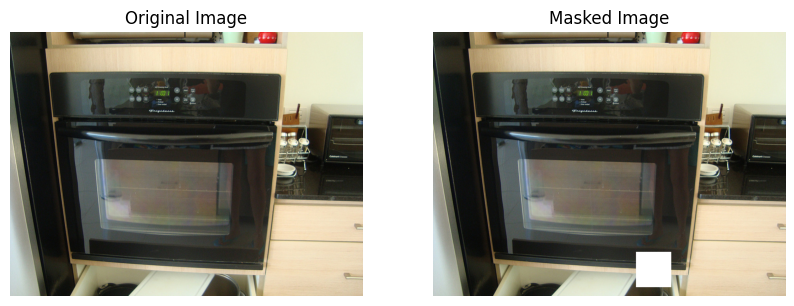

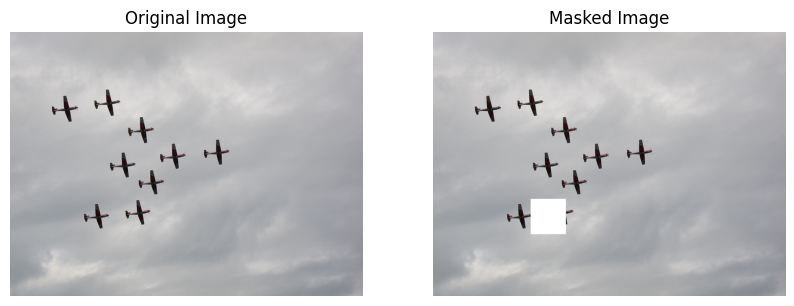

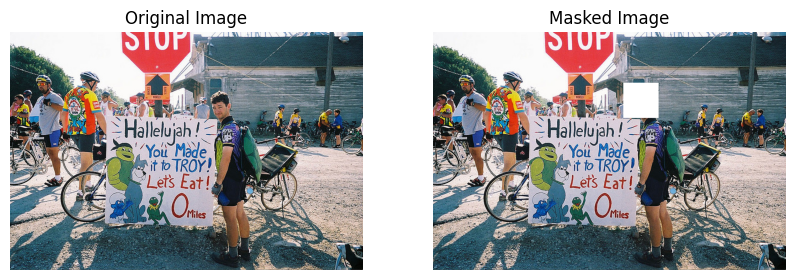

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import tensorflow as tf

class InpaintingDataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, mask_size=(64, 64)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.batch_size = batch_size
        self.mask_size = mask_size

    def __len__(self):
        return math.ceil(len(self.image_names) / self.batch_size)

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, len(self.image_names))
        batch_image_names = self.image_names[batch_start:batch_end]

        images, masked_images, masks = [], [], []
        for img_name in batch_image_names:
            img_path = os.path.join(self.image_dir, img_name)
            img = load_img(img_path)
            img = img_to_array(img) / 255.0  # Normalize images
            img_size = img.shape[:2]  # Get image size (height, width)

            mask = np.zeros((img_size[0], img_size[1], 1), dtype=np.float32)
            top_left_x = np.random.randint(0, img_size[0] - self.mask_size[0])
            top_left_y = np.random.randint(0, img_size[1] - self.mask_size[1])
            mask[top_left_x:top_left_x + self.mask_size[0], top_left_y:top_left_y + self.mask_size[1], :] = 1

            masked_img = img.copy()
            masked_img[mask[:, :, 0] == 1] = 1  # Mask with white color

            images.append(img)
            masked_images.append(masked_img)
            masks.append(mask)

        return [masked_images, masks], images
    
def display_image_pairs(generator, num_samples=3):
    data = next(iter(generator))
    masked_images, masks = data[0]
    original_images = data[1]
    
    for i in range(num_samples):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
        axs[0].imshow(original_images[i])
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(masked_images[i])
        axs[1].set_title("Masked Image")
        axs[1].axis('off')

        plt.show()

# Usage example:
train_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
train_generator = InpaintingDataGenerator(train_image_dir, batch_size=3)  # Batch size equals num_samples for display
display_image_pairs(train_generator, num_samples=3)


In [4]:
import os

def count_elements_in_folder(folder_path):
    """
    Counts the number of elements (files and subdirectories) in the specified folder.

    Args:
    - folder_path (str): Path to the folder.

    Returns:
    - int: Number of elements in the folder.
    """
    try:
        elements = os.listdir(folder_path)
        return len(elements)
    except FileNotFoundError:
        print(f"The folder at {folder_path} was not found.")
        return 0
    except NotADirectoryError:
        print(f"The path provided is not a directory.")
        return 0
    except PermissionError:
        print(f"Permission denied for accessing the directory.")
        return 0

# Usage example:
train_path = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
test_path = '/kaggle/input/coco-2017-dataset/coco2017/test2017'
val_path = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
train_num = count_elements_in_folder(val_path)
val_num = count_elements_in_folder(test_path)
test_num = count_elements_in_folder(train_path)
print(f"The test folder contains {test_num} elements.")
print(f"The train folder contains {train_num} elements.")
print(f"The validation folder contains {val_num} elements.")

The test folder contains 118287 elements.
The train folder contains 5000 elements.
The validation folder contains 40670 elements.


# TPU BELOW - DO POPRAWY

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import math

# Connect to the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print('Not connected to a TPU runtime. Using CPU/GPU strategy')
    strategy = tf.distribute.get_strategy()

class InpaintingDataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, mask_size=(64, 64)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.batch_size = batch_size
        self.mask_size = mask_size

    def __len__(self):
        return math.ceil(len(self.image_names) / self.batch_size)

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, len(self.image_names))
        batch_image_names = self.image_names[batch_start:batch_end]

        images, masked_images, masks = [], [], []
        for img_name in batch_image_names:
            img_path = os.path.join(self.image_dir, img_name)
            img = load_img(img_path)
            img = img_to_array(img) / 255.0  # Normalize images
            img_size = img.shape[:2]  # Get image size (height, width)

            mask = np.zeros((img_size[0], img_size[1], 1), dtype=np.float32)
            top_left_x = np.random.randint(0, img_size[0] - self.mask_size[0])
            top_left_y = np.random.randint(0, img_size[1] - self.mask_size[1])
            mask[top_left_x:top_left_x + self.mask_size[0], top_left_y:top_left_y + self.mask_size[1], :] = 1

            masked_img = img.copy()
            masked_img[mask[:, :, 0] == 1] = 1  # Mask with white color

            images.append(img)
            masked_images.append(masked_img)
            masks.append(mask)

        return [masked_images, masks], images
    
train_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
test_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/test2017'

# Adjust batch size for TPU (TPUs require batch sizes that are a multiple of 8)
batch_size = 64 * strategy.num_replicas_in_sync

train_generator = InpaintingDataGenerator(train_image_dir, batch_size)
val_generator = InpaintingDataGenerator(val_image_dir, batch_size)
test_generator = InpaintingDataGenerator(test_image_dir, batch_size)

# Convert the model to be compatible with the TPU
with strategy.scope():
    final_model = final_model  # Assuming final_model is already defined and compiled

callbacks = [
    ModelCheckpoint('best_inpainting_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = final_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate on test set
test_loss = final_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')

# Save the model
final_model.save('final_inpainting_model.h5')

# NAJNOWSZY

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

class InpaintingDataGenerator:
    def __init__(self, image_dir, batch_size, mask_size=(64, 64), target_size=(256, 256)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.batch_size = batch_size
        self.mask_size = mask_size
        self.target_size = target_size
        self.dataset = self.create_dataset()
    
    def create_dataset(self):
        # Create a dataset of file paths
        path_dataset = tf.data.Dataset.from_tensor_slices(self.image_names)
    
        # Map the file paths to images, masks, and masked images
        image_dataset = path_dataset.map(
            lambda x: self.load_and_preprocess_image(
                self.image_dir, tf.strings.split(x, os.sep)[-1]  # Pass directory and filename separately
            ), 
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
        # Batch and prefetch
        image_dataset = image_dataset.batch(self.batch_size)
        image_dataset = image_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
        return image_dataset

    
    def load_and_preprocess_image(self, dir_path, filename):
        # Combine the directory and filename to get the full path to the image
        img_path = tf.strings.join([dir_path, filename], separator='/')
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, self.target_size)
        # Create mask
        img_size = tf.shape(img)[:2]
        mask = tf.zeros((img_size[0], img_size[1], 1), dtype=tf.float32)
        top_left_x = tf.random.uniform((), 0, img_size[0] - self.mask_size[0], dtype=tf.int32)
        top_left_y = tf.random.uniform((), 0, img_size[1] - self.mask_size[1], dtype=tf.int32)
        bottom_right_x = top_left_x + self.mask_size[0]
        bottom_right_y = top_left_y + self.mask_size[1]

        # Generate indices for the mask
        indices = tf.reshape(
            tf.stack(
                tf.meshgrid(
                    tf.range(top_left_x, bottom_right_x),
                    tf.range(top_left_y, bottom_right_y),
                    indexing='ij'
                ),
                axis=-1
            ),
            (-1, 2)
        )
    
        # Create updates for the mask
        updates = tf.ones((self.mask_size[0] * self.mask_size[1], 1), dtype=tf.float32)

        # Update the mask tensor
        mask = tf.tensor_scatter_nd_update(mask, indices, updates)

        # Apply mask
        masked_img = img * (1 - mask) + mask

        # Return a tuple of two elements:
        # 1. a list containing the masked image and the mask
        # 2. the original image (as ground truth for training)
        return (masked_img, mask), img
    
train_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
test_image_dir = '/kaggle/input/coco-2017-dataset/coco2017/test2017'

batch_size = 32 

train_generator = InpaintingDataGenerator(train_image_dir, batch_size, target_size=(640, 480))
val_generator = InpaintingDataGenerator(val_image_dir, batch_size, target_size=(640, 480))
test_generator = InpaintingDataGenerator(test_image_dir, batch_size, target_size=(640, 480))

callbacks = [
    ModelCheckpoint('best_inpainting_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Directly compile and fit the model, no strategy.scope() needed
final_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
num_train_samples = len(train_generator.image_names)
num_val_samples = len(val_generator.image_names)
num_test_samples = len(test_generator.image_names)

history = final_model.fit(
    train_generator.dataset,
    epochs=100,
    steps_per_epoch=num_train_samples // batch_size,  # Use the entire training set
    validation_data=val_generator.dataset,
    validation_steps=num_val_samples // batch_size,  # Use the entire validation set
    callbacks=callbacks
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate on test set
test_loss = final_model.evaluate(
    test_generator.dataset,
    steps=num_test_samples // batch_size  # Use the entire test set
)
print(f'Test Loss: {test_loss}')

def display_inpainting_results(model, generator, num_samples=3):
    # Take a sample batch from the generator
    [masked_images, masks], original_images = next(iter(generator.dataset))
    
    # Predict inpainted images
    inpainted_images = model.predict([masked_images, masks])
    
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        
        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(original_images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        # Masked Image
        plt.subplot(1, 3, 2)
        plt.imshow(masked_images[i])
        plt.title('Masked Image')
        plt.axis('off')
        
        # Inpainted Image
        plt.subplot(1, 3, 3)
        plt.imshow(inpainted_images[i])
        plt.title('Inpainted Image')
        plt.axis('off')
        
        plt.show()

# Display inpainting results
display_inpainting_results(final_model, test_generator, num_samples=6)

# Save the model
final_model.save('final_inpainting_model.h5')

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'model_2/model_1/contextual_attention/Reshape' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_320/852606555.py", line 101, in <module>
      history = final_model.fit(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_320/2983938491.py", line 115, in call
      raw_w = tf.reshape(raw_w, [background_shape[0], -1, self.ksize, self.ksize, background_shape[-1]])
Node: 'model_2/model_1/contextual_attention/Reshape'
Input to reshape is a tensor with 1926758400 values, but the requested shape requires a multiple of 864
	 [[{{node model_2/model_1/contextual_attention/Reshape}}]] [Op:__inference_train_function_16075]

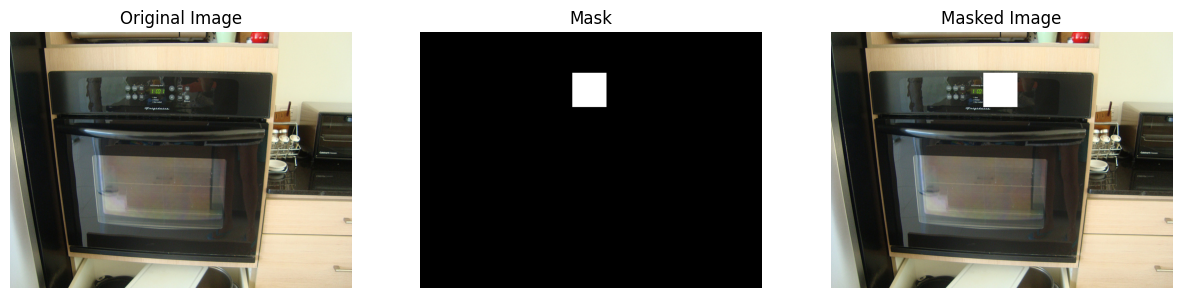

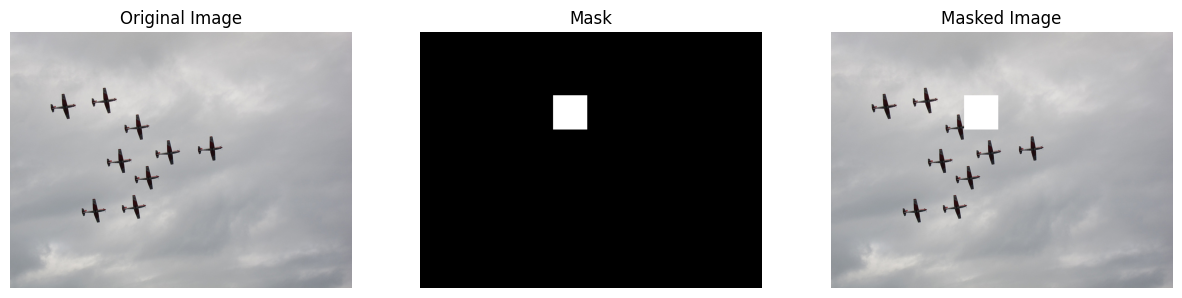

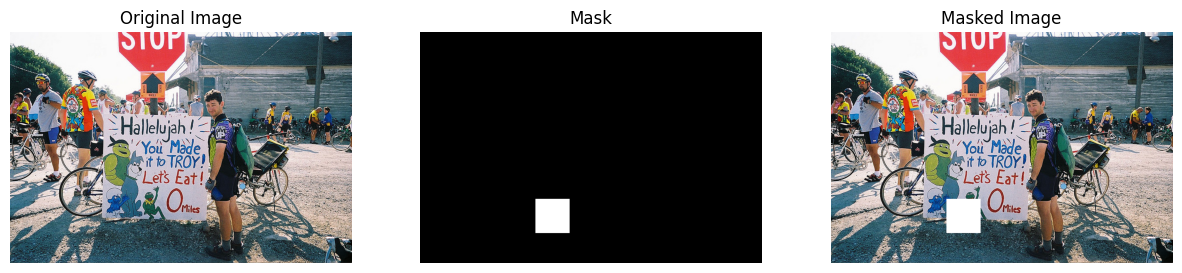

In [3]:
def visualize_data(generator, num_samples=3):
    # Fetch a batch of data
    [masked_images, masks], original_images = next(iter(generator))
    
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        
        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(original_images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        # Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i][:, :, 0], cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        
        # Masked Image
        plt.subplot(1, 3, 3)
        plt.imshow(masked_images[i])
        plt.title('Masked Image')
        plt.axis('off')
        
        plt.show()

# Visualize a few samples
visualize_data(train_generator, num_samples=3)
